In [34]:
import awkward as ak
import uproot
import numpy as np
import matplotlib.pyplot as plt
import sys
import yaml
import matplotlib.pyplot as plt
import matplotlib as mpl
from numpy import genfromtxt

sys.path.append('/home/jbohm/start_tf/LCStudies')
from  util import graph_util as gu
from data import particle_data_visualize_plot_utils as pu

In [303]:
MASK_OUT = -1
# compute mse per cluster and then average over batch or file
def mse_batch(labels, preds):
    return np.mean(np.mean(np.square(labels - preds), axis=1))

def mse_batch_no_pad(preds, labels):
    sum = 0
    count = 0
    for clus_idx, clus_labels in enumerate(labels):
        cut_padding = (clus_labels != MASK_OUT)
        if len(clus_labels[cut_padding]) > 0:
            sum += np.mean(np.square(clus_labels[cut_padding] - preds[clus_idx][cut_padding]))
            count += 1

    return sum / count

# slice and plot loss
def plot_batch_loss(all_loss, batch_low=None, batch_high=None):
    batch_high = len(all_loss) if batch_high == None else batch_high
    batch_low = 0 if batch_low == None else batch_low
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(np.arange(batch_low, batch_high), all_loss[batch_low:batch_high])
    plt.xlabel("batch")
    plt.ylabel("loss")
    plt.show()

def plot_epoch_loss(train_loss, val_loss):
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(train_loss, label="train")
    plt.plot(val_loss, label="val")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

def get_history(file_name):
    return np.load("/fast_scratch_1/jbohm/train_testing_data/pointnet_train_1/" + file_name, allow_pickle=True)

def plot_clus_pred_acc(clus_idx, preds, labels, verbose=False, point_low=None, point_high=None):
    if point_low == None and point_high == None:
        point_low = 0
        point_high = len(labels[clus_idx][cut_padding]) + 10
    cut_padding = labels[clus_idx] != MASK_OUT
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.scatter(np.arange(point_low, point_high), labels[clus_idx][point_low:point_high], label="truth")
    plt.scatter(np.arange(point_low, point_high), preds[clus_idx][point_low:point_high], label="preds")
    plt.plot(np.arange(point_low, point_high), np.repeat(np.mean(labels[clus_idx][cut_padding]), point_high - point_low), color="grey")
    plt.xlabel("point")
    plt.ylabel("EM frac")
    plt.title("Cluster " + str(clus_idx))
    plt.legend()
    plt.show()
    if verbose:
        print("cluster" + str(clus_idx) + ", cells " + str(point_low) + " to " + point_high)
        print("predicted EM frac:")
        print(preds[clus_idx][point_low:point_high].flatten())
        print("truth:")
        print(labels[clus_idx][point_low:point_high].flatten())

def plot_clus_preds_acc(clus_idxs, preds, labels, epochs, verbose=False, point_low=None, point_high=None):
    calc_range = False
    if point_low == None and point_high == None:
        calc_range = True
    
    for clus_idx in clus_idxs:
        cut_padding = labels[clus_idx] != MASK_OUT
        if calc_range:
            point_low = 0
            point_high = min(len(labels[clus_idx][cut_padding]) + 10, len(labels[clus_idx]))
        fig = plt.figure(figsize=(15,3))
        fig.patch.set_facecolor('white')
        plt.scatter(np.arange(point_low, point_high), labels[clus_idx][point_low:point_high], label="truth")
        for epoch in epochs:
            plt.scatter(np.arange(point_low, point_high), preds[epoch][clus_idx][point_low:point_high], label="epoch " + str(epoch))
        plt.plot(np.arange(point_low, point_high), np.repeat(np.mean(labels[clus_idx][cut_padding]), point_high - point_low), color="grey")
        plt.xlabel("point")
        plt.ylabel("EM frac")
        plt.title("Cluster " + str(clus_idx) + " preds")
        plt.legend()
        plt.show()

    # plot hist of all clusters
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    cut_padding_all_clus = labels != MASK_OUT
    data = [labels[cut_padding_all_clus].flatten()]
    labels = ["truth"]
    for epoch in epochs:
        data.append(preds[epoch][cut_padding_all_clus].flatten())
        labels.append("epoch " + str(epoch))

    pu.plot_overlay_hist(data, 75, "All clusters predictions", "EM frac", "frequency", labels)

def plot_all_clus_acc(history):
    cut_padding = (history["labels"] != -1)
    all_labels = history["labels"][cut_padding].flatten()
    all_preds = history["preds"][cut_padding].flatten()
    pu.plot_overlay_hist([all_labels, all_preds], 100, "All clusters", "EM frac", "frequency", ["truth", "preds"])
    
def pointwise_loss_func(y_true, y_pred):
    # find out which timesteps in `y_true` are not the padding character '#'
    mask = np.equal(y_true, MASK_OUT)
    mask = 1 - mask

    # multiply mse with the mask
    loss = np.square(y_true - y_pred) * mask

    # take average w.r.t. the number of unmasked entries
    out = np.sum(loss) / np.sum(mask) # flattens data
    return out

def batch_wise_loss_func(y_true, y_pred):
    # find out which timesteps in `y_true` are not the padding character '#'
    mask = np.equal(y_true, MASK_OUT)
    mask = 1 - mask

    # multiply mse with the mask
    loss = np.square(y_true - y_pred) * mask

    # take average w.r.t. the number of unmasked entries
    out = np.sum(loss, axis=1) / np.sum(mask, axis=1) # flattens data
    return np.mean(out)

In [304]:
def train_summary_stats(file_name, num_epochs, clusters=[], batch_loss=False):
    # load all train data
    dir = '/fast_scratch_1/jbohm/train_testing_data/pointnet_train' + file_name 
    loss_data = genfromtxt(dir + "/log_loss.csv", delimiter=',').transpose()
    loss = loss_data[1]
    val_loss = loss_data[2]

    preds = []
    mse_batch_loss = []
    pointwise_loss = []
    labels = np.load(dir + "/tests/labels_5_files.npy")
    for epoch in range(num_epochs):
        preds.append(np.load(dir + "/tests/preds_5_files_" + str(epoch) + ".npy"))
        mse_batch_loss.append(mse_batch_no_pad(preds[epoch], labels))
        pointwise_loss.append(pointwise_loss_func(labels, preds[epoch]))

    # plot train and val loss
    plot_epoch_loss(loss, val_loss)

    # plot manually computed mse batch loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(mse_batch_loss)
    plt.xlabel("epoch")
    plt.ylabel("test loss")
    plt.show()

    # plot manually computed mse batch loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(mse_batch_loss)
    plt.xlabel("epoch")
    plt.ylabel("test loss")
    plt.show()

    print("test (batchwise)", mse_batch_loss)
    print("test (pointwise)", pointwise_loss)

    # plot clusters preds/labels over epochs
    epochs = [0]
    if num_epochs != 1:
        epochs.append(num_epochs - 1)

    plot_clus_preds_acc(clusters, preds, labels, epochs)

    if batch_loss:
        loss = np.load(dir + "/history_epochs_0_to_1.npz", allow_pickle=True)["batch_end_loss"].item()
        fig = plt.figure()
        fig.patch.set_facecolor('white')
        plt.plot(loss)
        plt.xlabel("epoch")
        plt.ylabel("batch loss")
        plt.show()


In [617]:
def plot_preds_vs_truth(file_name, epoch):
    dir = '/fast_scratch_1/jbohm/train_testing_data/pointnet_train' + file_name

    preds = np.load(dir + "/tests/preds_5_files_" + str(epoch) + ".npy")
    labels = np.load(dir + "/tests/labels_5_files.npy")
    cut_unmasked = labels != MASK_OUT

    fig = plt.figure(figsize=(8, 6.5))
    fig.patch.set_facecolor('white')
    plt.hist2d(labels[cut_unmasked], preds[cut_unmasked], (50,50), range=((0,1),(0,1)), cmap=plt.cm.magma_r, norm=mpl.colors.LogNorm())
    plt.xlabel("EM frac truth")
    plt.ylabel("EM frac pred")
    plt.colorbar(label="frequency")
    plt.show()

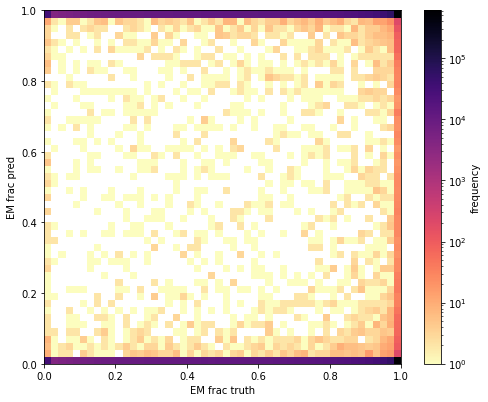

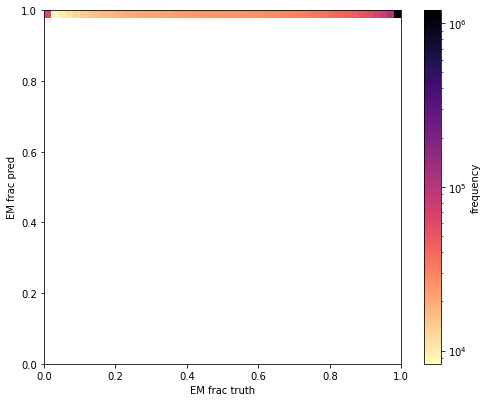

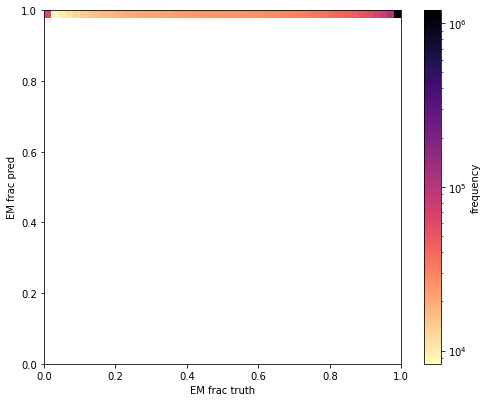

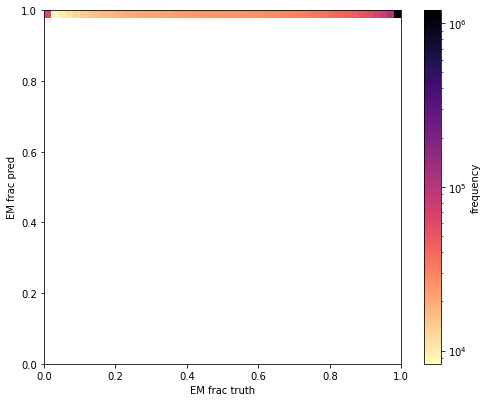

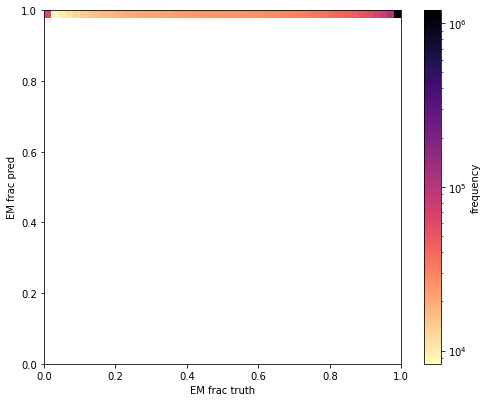

In [490]:
plot_preds_vs_truth("_2/beta_tr_26_val_5_continous_dataset", 12)

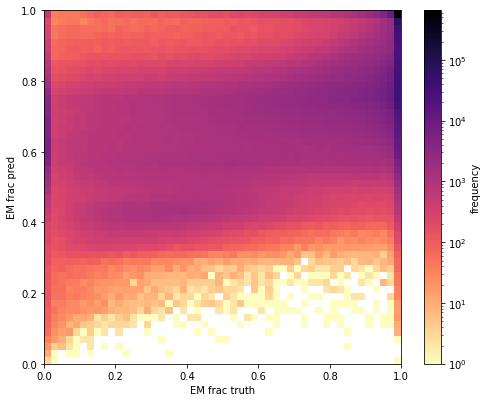

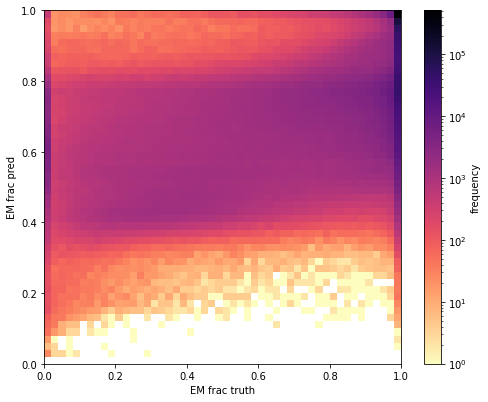

In [621]:
plot_preds_vs_truth("_2/gamma_325_tr_40_tst_40_val_10_epoch_BN_cartesian_stacked_output_weight_points_equal", 12)
plot_preds_vs_truth("_2/gamma_325_tr_40_tst_40_val_10_epoch_BN_spherical_stacked_output_weight_points_equal", 12)

In [608]:
num_epochs = 5
file_name = "_2/gamma_325_tr_40_tst_40_val_10_epoch_BN_cartesian_weight_points_equal"
dir = '/fast_scratch_1/jbohm/train_testing_data/pointnet_train' + file_name 
loss_data = genfromtxt(dir + "/log_loss.csv", delimiter=',').transpose()
loss = loss_data[1]
val_loss = loss_data[2]

preds = []
mse_batch_loss = []
labels = np.load(dir + "/tests/labels_5_files.npy")
for epoch in range(num_epochs):
    preds.append(np.load(dir + "/tests/preds_5_files_" + str(epoch) + ".npy"))
    mse_batch_loss.append(mse_batch_no_pad(preds[epoch], labels))


In [609]:
# Leading cells EM frac plotting functions
def plot_leading_cells_energy(cell_nums, preds, labels, bins=100):
    cut_padding = (labels != MASK_OUT)
    for cell_num in cell_nums:
        labels_cut = labels[:, cell_num, :][cut_padding[:, cell_num, :]]
        preds_cut = preds[:, cell_num, :][cut_padding[:, cell_num, :]]
        pu.plot_overlay_hist([labels_cut, preds_cut], bins, "Leading cells " + str(cell_num), "EM frac", "frequency", ["truth", "preds"])

def plot_leading_cells_energy_frac(cell_nums, preds, labels, bins=100, frac=2):
    cut_padding = (labels != MASK_OUT)
    for cell_num in cell_nums:
        labels_cut = labels[:, cell_num, :][cut_padding[:, cell_num, :]]
        preds_cut = preds[:, cell_num, :][cut_padding[:, cell_num, :]]

        labels_counts, bins = np.histogram(labels_cut, bins)
        preds_counts, bins = np.histogram(preds_cut, bins)
        # np.histogram return bin edges (len = bin values + 1), and bin values
        

        # normalize counts
        labels_counts = labels_counts / np.sum(labels_counts)
        preds_counts = preds_counts / np.sum(preds_counts)

        if frac == 1:
            # measure of simularity:
            #   2 - pred_counts/truth_counts, if pred_counts > truth_counts
            #   truth_counts / pred_counts, otherwise
            true_pred_frac = [2 - preds_counts[i]/labels_counts[i] if labels_counts[i] > preds_counts[i] else labels_counts[i]/preds_counts[i] for i in range(len(labels_counts))]
            true_pred_frac = np.nan_to_num(true_pred_frac, nan=1)

            fig = plt.figure(figsize=(6,1.5))
            fig.patch.set_facecolor('white')
            plt.step(bins[:-1], true_pred_frac, where="pre")
            plt.fill_between(bins[:-1],true_pred_frac, y2=1, step="pre", alpha=0.4)
            plt.plot(bins, np.repeat(1, len(bins)), color="grey")
            plt.ylim((0, 2.25))
            plt.ylabel("truth/pred ratio")


            
        if frac == 2:
            # use a scaled distance metric
            #  (truth_counts - pred_counts) / (truth_counts + pred_counts)
            true_pred_frac = [(labels_counts[i] - preds_counts[i])/(labels_counts[i] + preds_counts[i] if labels_counts[i] + preds_counts[i] > 0 else 1) for i in range(len(labels_counts))]

            fig = plt.figure(figsize=(6,1.5))
            fig.patch.set_facecolor('white')
            plt.step(bins[:-1], true_pred_frac, where="pre")
            plt.fill_between(bins[:-1],true_pred_frac, y2=0, step="pre", alpha=0.4)
            plt.plot(bins, np.repeat(0, len(bins)), color="grey")
            plt.ylabel("(true-pred)/(true+pred)")


        
        plt.title("Leading cells " + str(cell_num))
        plt.xlabel("EM frac")
        plt.show()

def plot_leading_cell_energy_and_frac(cell_num, preds, labels, bins):
    fig, axs = plt.subplots(2,1,figsize=(8,6), gridspec_kw={'height_ratios': [3, 1]})

    cut_padding = (labels != MASK_OUT)
    labels_cut = labels[:, cell_num, :][cut_padding[:, cell_num, :]]
    preds_cut = preds[:, cell_num, :][cut_padding[:, cell_num, :]]
    
    # axs[0] - plot leading cell_num EM frac for labels vs preds
    data = [labels_cut, preds_cut]
    labels = ["truth", "preds"]
    for i, data in enumerate(data):
        counts, bins = np.histogram(data, bins, range=(0,1))
        # normalize counts
        counts = counts / np.sum(counts)
        axs[0].stairs(counts, bins, label=labels[i])
    axs[0].set_ylabel("frequency")
    axs[0].legend(loc="upper left")
    
    # axs[1] - plot prediction error
    labels_counts, bins = np.histogram(labels_cut, bins, range=(0,1))
    preds_counts, bins = np.histogram(preds_cut, bins, range=(0,1))

    # np.histogram return bin edges (len = bin values + 1), and bin values

    # use a scaled distance metric
        #  (truth_counts - pred_counts) / (truth_counts + pred_counts)
    true_pred_frac = [(labels_counts[i] - preds_counts[i])/(labels_counts[i] + preds_counts[i] if labels_counts[i] + preds_counts[i] > 0 else 1) for i in range(len(labels_counts))]

    # normalize counts
    labels_counts = labels_counts / np.sum(labels_counts)
    preds_counts = preds_counts / np.sum(preds_counts)
    axs[1].step(bins, [0] + true_pred_frac)
    axs[1].fill_between(bins, true_pred_frac + [0], y2=0, step="post", alpha=0.4)
    axs[1].plot(bins, np.repeat(0, len(bins)), color="grey")
    axs[i].set_ylim((-1.2,1.2))
    axs[1].set_ylabel("(true-pred)/(true+pred)")
    axs[1].yaxis.labelpad = 3

    axs[1].set_xlabel("EM frac")
    axs[0].set_title("Leading cell " + str(cell_num) + " truth vs pred EM frac")


In [610]:
def plot_leading_cells_energy_frac_same_axis(cell_nums, preds, labels, bins=100, frac=2):
    cut_padding = (labels != MASK_OUT)

    fig = plt.figure(figsize=(2*len(cell_nums), 6))
    gs = fig.add_gridspec(1, len(cell_nums), hspace=0)
    axs = gs.subplots(sharex=True, sharey=True)

    for i, cell_num in enumerate(cell_nums):
        labels_cut = labels[:, cell_num, :][cut_padding[:, cell_num, :]]
        preds_cut = preds[:, cell_num, :][cut_padding[:, cell_num, :]]

        labels_counts, bins = np.histogram(labels_cut, bins, range=(0,1))
        preds_counts, bins = np.histogram(preds_cut, bins, range=(0,1))
        # np.histogram return bin edges (len = bin values + 1), and bin values
        

        # normalize counts
        labels_counts = labels_counts / np.sum(labels_counts)
        preds_counts = preds_counts / np.sum(preds_counts)

         # use a scaled distance metric
            #  (truth_counts - pred_counts) / (truth_counts + pred_counts)
        true_pred_frac = [(labels_counts[i] - preds_counts[i])/(labels_counts[i] + preds_counts[i] if labels_counts[i] + preds_counts[i] > 0 else 1) for i in range(len(labels_counts))]
        
        axs[i].step(true_pred_frac + [0], bins)
        axs[i].fill_betweenx(bins, true_pred_frac + [0], 0, step="post", alpha=0.4)
        axs[i].plot(np.repeat(0, len(bins)), bins, color="grey")
        axs[i].set_xlabel(cell_nums[i], fontsize=14)
        axs[i].set_xlim((-1.1,1.1))

    # Hide x labels and tick labels for all but bottom plot.
    for ax in axs:
        ax.label_outer()
    
    fig.supxlabel("Leading cell's prediction error [(true-pred)/(true+pred)]", fontsize=16)
    axs[0].set_ylabel("EM fraction", fontsize=16)
    fig.suptitle("Leading cells prediction error vs EM fraction", fontsize=16)

    plt.show()

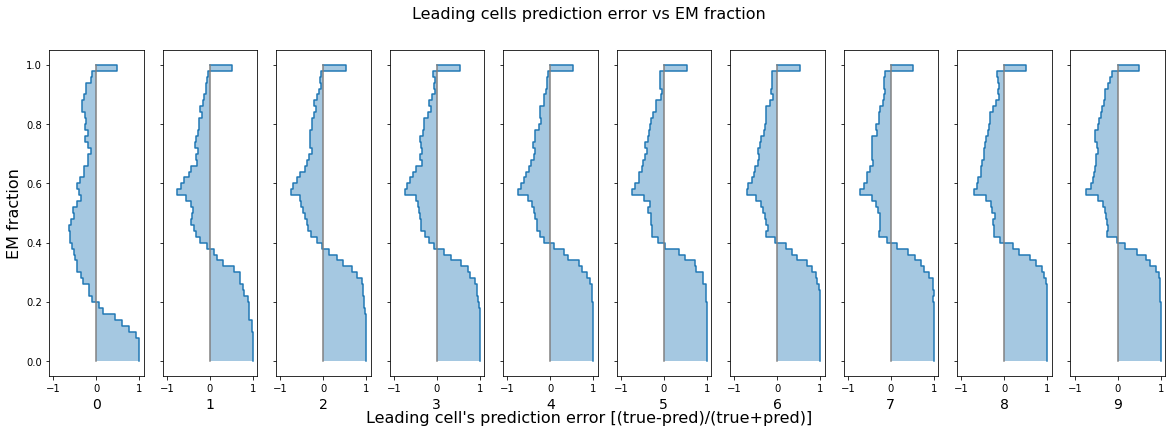

In [611]:
leading_cell_nums = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
plot_leading_cells_energy_frac_same_axis(leading_cell_nums, preds[3], labels, 50)

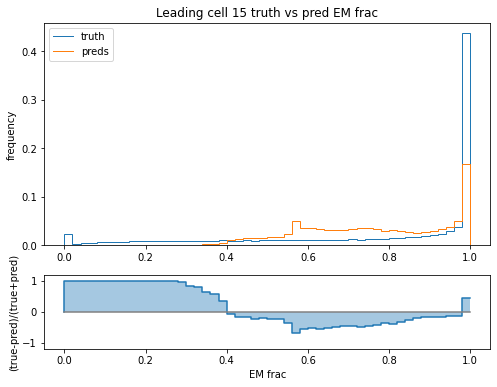

In [612]:
cell_num = 15
plot_leading_cell_energy_and_frac(cell_num, preds[3], labels, 50)